import the usefull libraries

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot

import re
import sklearn

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier

Predict the mortality by predicting their diseases. Heart disease Linked to high cholesteral.

Load the datasets: We just use the demongraphic and questionaire datasets

In [13]:
demography = pd.read_csv("demographic.csv")
question = pd.read_csv("questionnaire.csv")
labs = pd.read_csv("labs.csv")

before combining the datasets, let's check to see if they have shared column names 


In [24]:
demography_cols = demography.columns
question_cols = question.columns
print("The demog and question datasets share the {} column".format(set(demography_cols).intersection(question_cols)))
print("So will join them on this column")

#########check shaped of these columne
print("\nThe Shape of Demographics dataset: {}".format(demography.shape))
print("The Shape of Questionnaire dataset: {}".format(question.shape))

#####Join the two datasets on the unique number for respondants
dataset = demography.join(question.set_index('SEQN'), on='SEQN')
print("\nThe Shape of COMBINED dataset: {}**".format(dataset.shape))
print("\n** one less column since SEQN is shared")

The demog and question datasets share the {'SEQN'} column
So will join them on this column

The Shape of Demographics dataset: (10175, 47)
The Shape of Questionnaire dataset: (10175, 953)

The Shape of COMBINED dataset: (10175, 999)**

** one less column since SEQN is shared


Get informations in the  cholesteral levels 


In [27]:
cholesterol = labs[['SEQN','LBXTC']]
###On ajoute la variable cholesterol dans dataset
newdataset = dataset.join(cholesterol.set_index('SEQN'), on='SEQN')

print("Finally, add the cholesterol level (target) column.")
print("New Shape: {}".format(dataset.shape))

#######only keep the rows where we have cholesteral info and delete colums with null value
cleandataset = newdataset[newdataset['LBXTC'].isna() == False]
print("Filtering for records where we have Cholesterol info gives final shape: {}".format(dataset.shape))

Finally, add the cholesterol level (target) column.
New Shape: (10175, 999)
Filtering for records where we have Cholesterol info gives final shape: (10175, 999)


Let's define function to categorise the cholesteral level:

1 - OK

2 - Borderline high (patient at risk)

3 - high

In [28]:
def cholesterol_level(mg):
    """
    1 - OK
    2 - Borderline High (at risk)
    3 - High
    """
    if mg < 200.0:#### Normal
        return 1
    elif mg < 240:### Risqué[200,239]
        return 2
    else:#### Danger[240.........]
        return 3

Categirise the cholesterol as our target variable that w'll predict

In [32]:
cleandataset['Target'] = cleandataset['LBXTC'].apply(lambda x: cholesterol_level(x))
dataframe = cleandataset
print("Group cholesterol levels in to 3 categories:")
print("1 - OK")
print("\n2 - Borderline High (at risk)")
print("\n3 - High")

print("\nWith the following totals:")
print(dataframe['Target'].value_counts())

Group cholesterol levels in to 3 categories:
1 - OK

2 - Borderline High (at risk)

3 - High

With the following totals:
1    5487
2    1525
3     612
Name: Target, dtype: int64


In this part, w'll do some feature selection based on removing columns containing many null values in each of the datasets.

Demographic feature selection


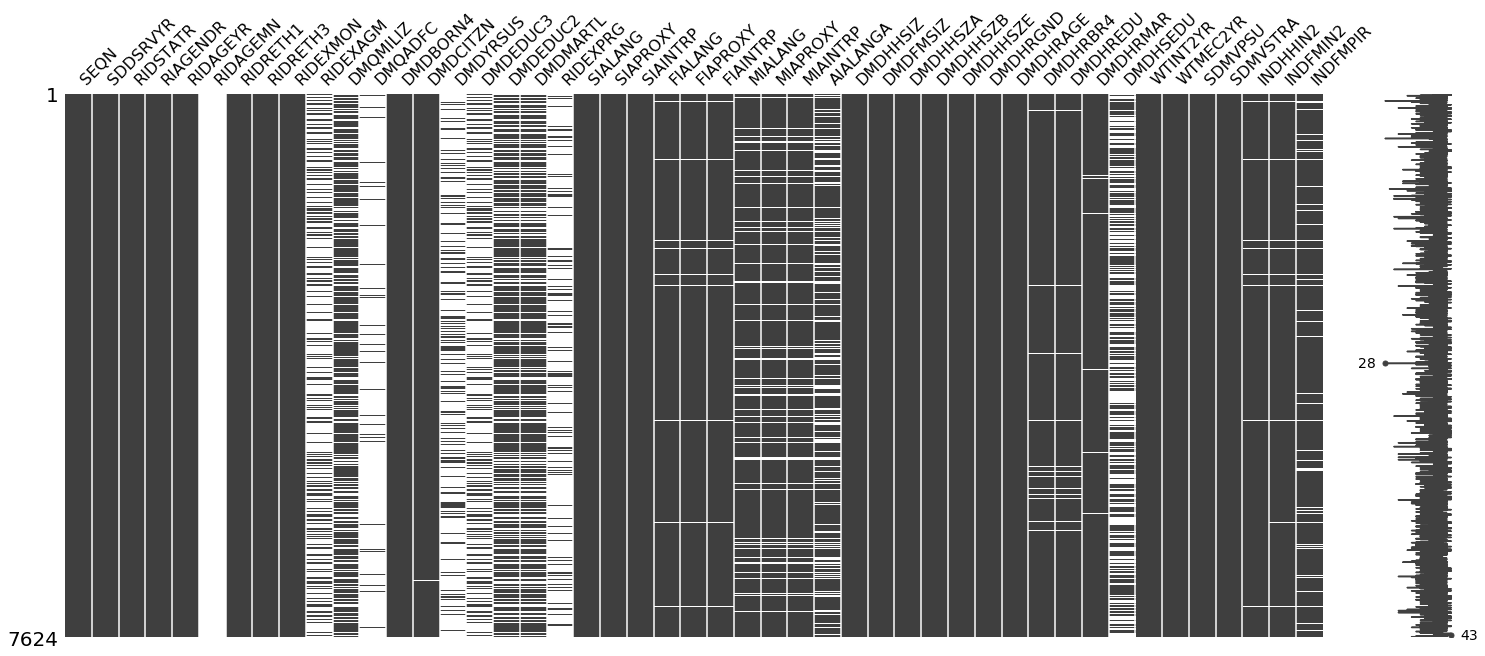

In [36]:
##### first check for the Demographics missing values
msno.matrix(dataframe.iloc[:, 0:47])

Let's visualise a list of these columns with missing values

Based on this result, we can:

$\bullet$ Remove those columsn with many missing values

$\bullet$Remove many of the other columns as well

$\bullet$Goal is to have a survey someone could fill out online or their mobile



Keep:

$\bullet$RIDAGEYR - Age

$\bullet$'WTINT2YR' - Weight

$\bullet$RIAGENDR - Gender

$\bullet$INDFMIN2- Total FAMIL income (need to remove 84 records?)

$\bullet$DMDFMSIZ Total number of people in the Family

$\bullet$DMDHHSIZ Total number of people in the Household

$\bullet$DMDHHSZA Number of children aged 5 years or younger in the household

$\bullet$DMDHHSZB Number of children aged 6-17 years old in the household

$\bullet$DMDHHSZE Number of adults aged 60 years or older in the household


In [68]:
demography_keep_cols = ['SEQN','RIAGENDR','WTINT2YR','RIDAGEYR','INDFMIN2','DMDHHSIZ','DMDHHSZA','DMDHHSZB','DMDHHSZE']

QUESTIONNAIRE Feature Selection


914 columns with 5% or more missing records


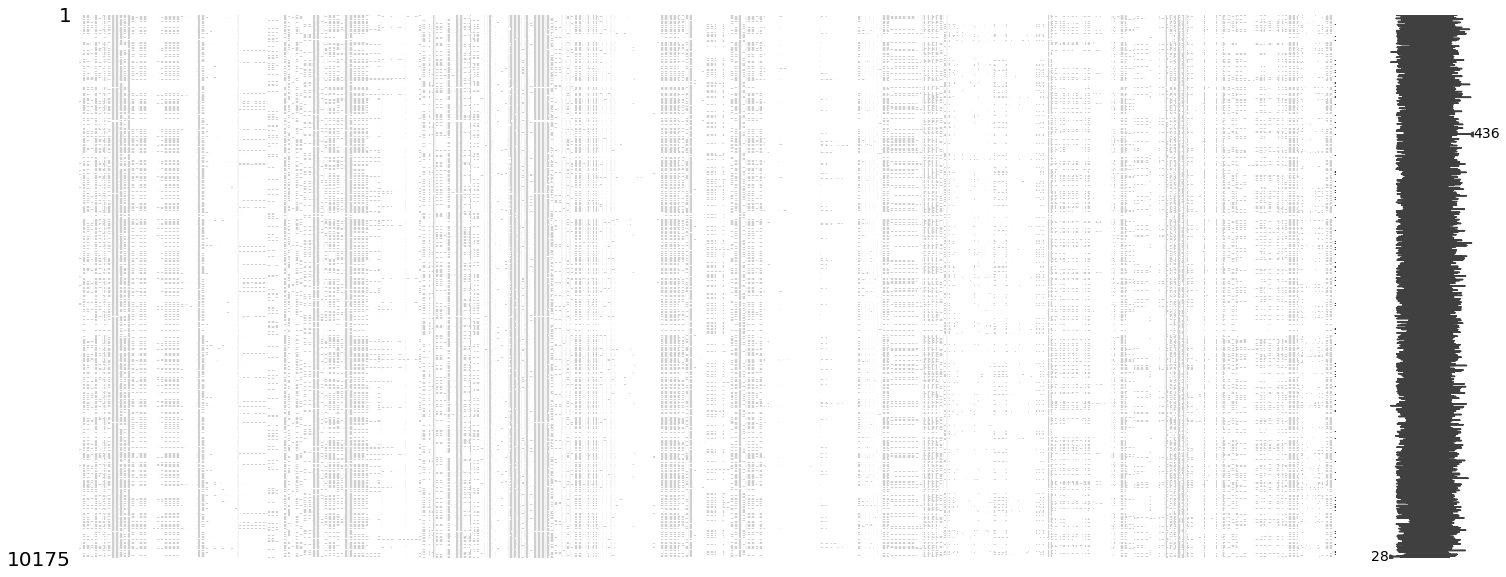

In [69]:
count_missing =[]
name_ques_missing =[]
for col, missing in zip(dataset.columns[48:],dataset.iloc[:,48:].isna().sum()):
    if missing > 380:
        count_missing.append(1)
        name_ques_missing.append(col)
print("{} columns with 5% or more missing records".format(len(count_missing)))
      
msno.matrix(dataset.iloc[:, 48:])

In this part, iI selected random variables

In [79]:
####Un ensemble de questions
question_keep_cols = ['DLQ010','DLQ020','DLQ040','DLQ050','DLQ060','MCQ010','MCQ053','MCQ082','MCQ086','MCQ092','MCQ203','HIQ011','HUQ051',
                  'HUQ071','HUQ090','PAQ710','PAQ715','DIQ010','SMD460','HOD050','HOQ065','INQ060','INQ080','INQ090','INQ132','INQ140',
                  'INQ150','CBD120','CBD130','FSD032A','FSD032B','FSD032C','FSD151','FSQ165','OHQ030']

In [80]:
keep_cols = demography_keep_cols + question_keep_cols + ['Target']
print("A total of {} columns to keep".format(len(keep_cols)))

A total of 45 columns to keep


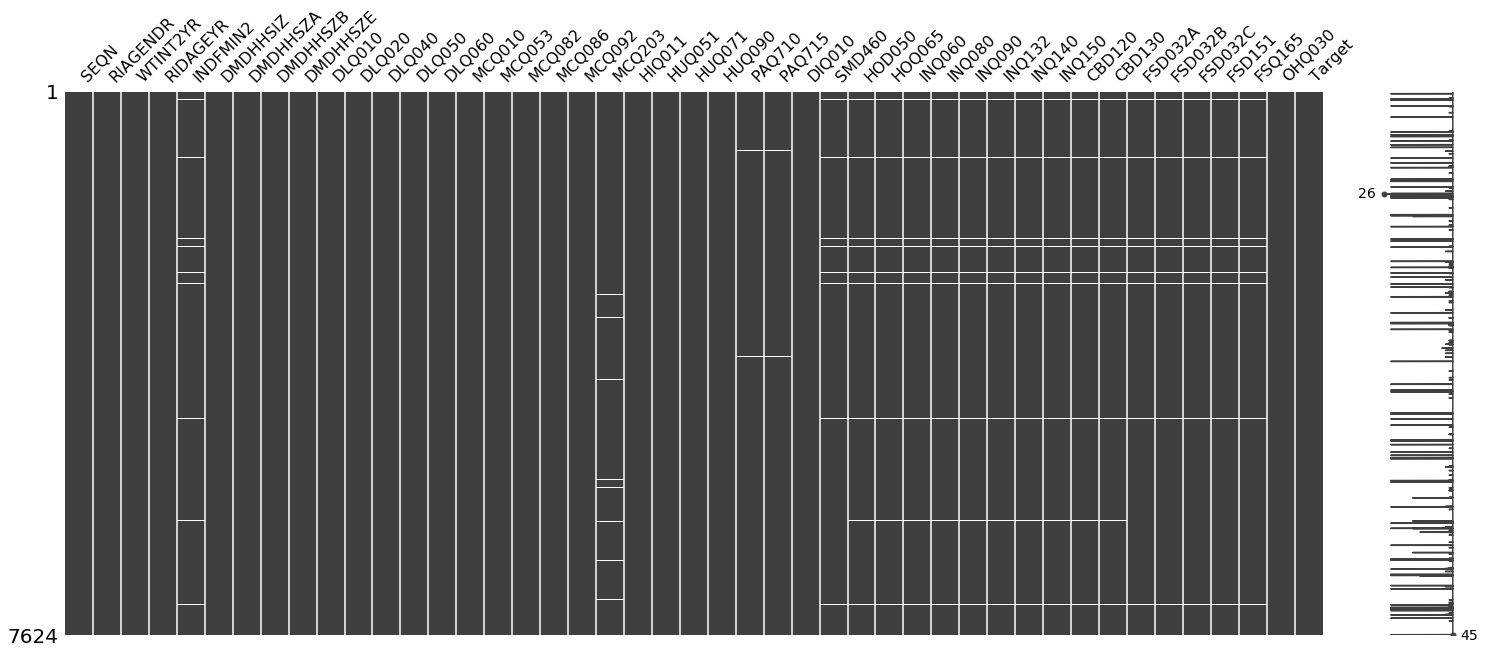

In [81]:
data = dataframe[keep_cols]
msno.matrix(data)

Let's remove the null values  in this new dataframe

In [82]:
dataclean = data.dropna(axis='index')
print("Final Dataset has {} unique records".format(len(dataclean['SEQN'].unique())))
print("{} missing data points".format(dataclean.isna().sum().sum()))

Final Dataset has 7431 unique records
0 missing data points


Ok Ok w've clean our datasets and done somme feature analisys, now let's explore the data

In [84]:
dataclean.head()

,SEQN,RIAGENDR,WTINT2YR,RIDAGEYR,INDFMIN2,DMDHHSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DLQ010,...,INQ150,CBD120,CBD130,FSD032A,FSD032B,FSD032C,FSD151,FSQ165,OHQ030,Target
0,73557,1,13281.237386,69,4.0,3,0,0,2,2.0,...,2.0,0.0,85.0,3.0,3.0,3.0,2.0,1.0,6.0,1
1,73558,1,23682.057386,54,7.0,4,0,2,0,2.0,...,2.0,40.0,20.0,3.0,3.0,3.0,2.0,1.0,6.0,1
2,73559,1,57214.803319,72,10.0,2,0,0,2,1.0,...,2.0,40.0,0.0,3.0,3.0,3.0,2.0,2.0,1.0,1
3,73560,1,55201.178592,9,9.0,4,0,2,0,2.0,...,1.0,50.0,30.0,3.0,3.0,3.0,2.0,2.0,1.0,1
4,73561,2,63709.667069,73,15.0,2,0,0,2,2.0,...,2.0,0.0,0.0,3.0,3.0,3.0,2.0,2.0,1.0,2


Target variable

As we see the plot, the values for high are relvatively low then we are going to re-categorize the problem as OK vs At Risk

This makes sense because if we identified someone as having Borderline-high 
or High we'd advise them to see doctor and get tested

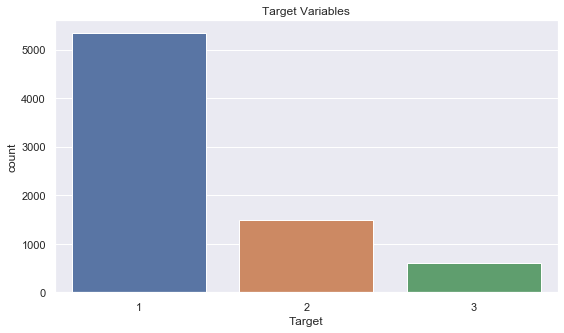

In [85]:
sns.set(rc={'figure.figsize':(9, 5)})
sns.countplot(dataclean['Target'])
plt.title("Target Variables")
plt.show()

In [86]:
def risk(level):
    
    if level == 1:
        return 0 # ther is no risk
    else:
        return 1 # patient is at risk

0    0.717938
1    0.282062
Name: Target, dtype: float64
0    5335
1    2096
Name: Target, dtype: int64


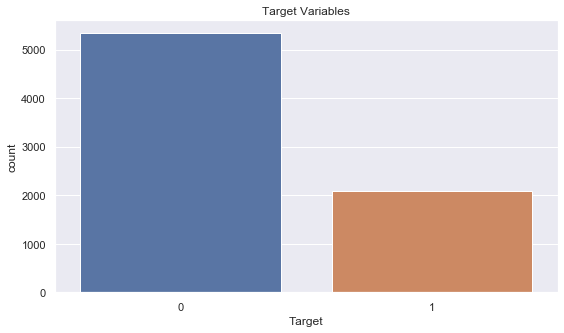

In [87]:
dataclean['Target'] = dataclean['Target'].apply(lambda x: risk(x))
print(dataclean.Target.value_counts() / dataclean.Target.count())  
print(dataclean.Target.value_counts())
# look at response variable
sns.set(rc={'figure.figsize':(9, 5)})
sns.countplot(dataclean['Target'])
plt.title("Target Variables")
plt.show()

Correlation between variables

In [88]:
def plot_corr_matrix(data):
    # analisys of correlation
    corrMatt = data.corr()
    mask = np.array(corrMatt)
    mask[np.tril_indices_from(mask)] = False
    plt.figure(figsize = (20,10))
    sns.heatmap(corrMatt, mask = mask, annot = True)

In [110]:
numerical_cols = ['WTINT2YR','RIDAGEYR','DMDHHSIZ','DMDHHSZA','DMDHHSZB','DMDHHSZE','HOD050','CBD120','CBD130']

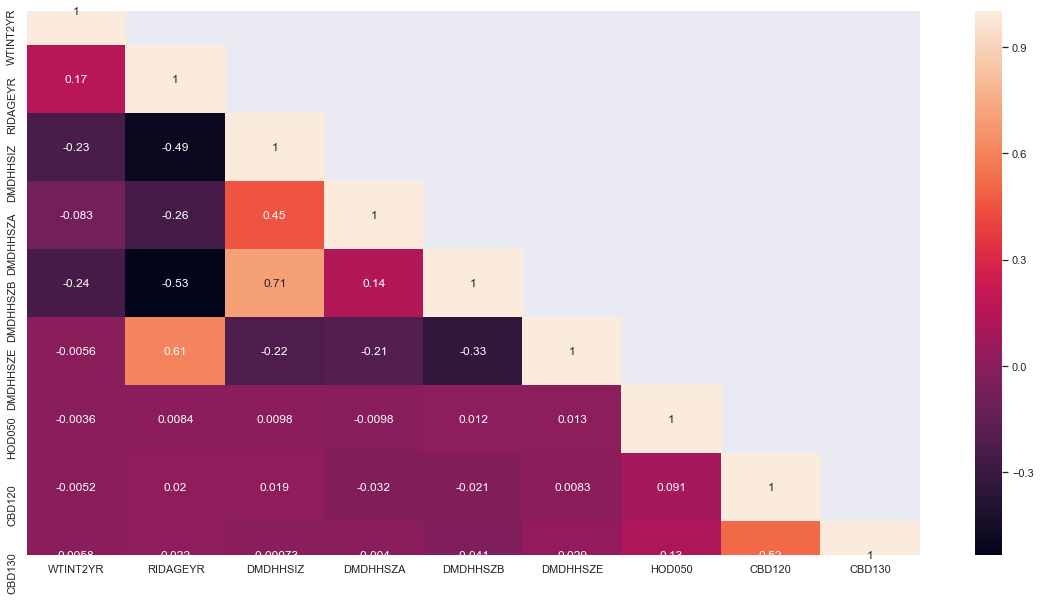

In [111]:
plot_corr_matrix(dataclean[numerical_cols])


In [4]:
dataframe1 = pd.read_csv('labs.csv')
dataframe2 = pd.read_csv('examination.csv')
dataframe3 = pd.read_csv('demographic.csv')
dataframe4 = pd.read_csv('diet.csv')
dataframe5 = pd.read_csv('questionnaire.csv')

dataframe2.drop(['SEQN'], axis = 1, inplace=True)
dataframe3.drop(['SEQN'], axis = 1, inplace=True)
dataframe4.drop(['SEQN'], axis = 1, inplace=True)
dataframe5.drop(['SEQN'], axis = 1, inplace=True)

df = pd.concat([dataframe1, dataframe2], axis=1, join='inner')
df = pd.concat([df, dataframe3], axis=1, join='inner')
df = pd.concat([df, dataframe4], axis=1, join='inner')
df = pd.concat([df, dataframe5], axis=1, join='inner')


####df.describe()

In [6]:
df['DMDHHSIZ']

0       3
1       4
2       2
3       4
4       2
       ..
9808    7
9809    6
9810    2
9811    4
9812    3
Name: DMDHHSIZ, Length: 9813, dtype: int64

There are many missing values in our dataset, in this step, w'll move missing values  

In [29]:
df.dropna(axis=1, how='all')###Si toutes les valeurs d'une ligne sont nulles, supprime toute la ligne
df.dropna(axis=0, how='all')###Si toutes les valeurs d'une colone sont nulles, supprime la colone

###Lets rename our columns
new_dataf = df.rename(columns = {'SEQN' : 'ID',
                          'RIAGENDR' : 'Gender',
                          'DMDYRSUS' : 'Years_in_US', ####Length of time the participant has been in the US. 
                          'INDFMPIR' : 'Family_income',###A ratio of family income to poverty guidelines.
                          'LBXGH' : 'GlycoHemoglobin',
                          'BMXARMC' : 'ArmCircum',
                          'BMDAVSAD' : 'SaggitalAbdominal',
                          'MGDCGSZ' : 'GripStrength',
                          'DRABF' : 'Breast_fed'})###nourris au sein

new_df = new_dataf.loc[:, ['ID', 'Gender', 'Years_in_US', 'Family_income','GlycoHemoglobin', 'ArmCircum', 
                'SaggitalAbdominal', 'GripStrength', 'Breast_fed']]

#df.describe()

In [30]:
new_df.head()

,ID,Gender,Years_in_US,Family_income,GlycoHemoglobin,ArmCircum,SaggitalAbdominal,GripStrength,Breast_fed
0,73557,1,NaN,0.84,13.9,35.3,20.6,55.2,2.0
1,73558,1,NaN,1.78,9.1,34.7,24.4,61.5,2.0
2,73559,1,NaN,4.51,8.9,33.5,25.6,91.0,2.0
3,73560,1,NaN,2.52,NaN,21.0,14.9,32.2,2.0
4,73561,2,NaN,5.00,4.9,25.2,NaN,30.9,2.0


In [31]:
from sklearn.feature_selection import VarianceThreshold


#Here we'll replace the (GlycoHemoglobin,SaggitalAbdominal,ArmCircum,GripStrength) null values by their median
new_df['GlycoHemoglobin'] = new_df['GlycoHemoglobin'].fillna(new_df['GlycoHemoglobin'].median())
new_df['SaggitalAbdominal'] = new_df['SaggitalAbdominal'].fillna(new_df['SaggitalAbdominal'].median())
new_df['ArmCircum'] = new_df['ArmCircum'].fillna(new_df['ArmCircum'].median())
new_df['GripStrength'] = new_df['GripStrength'].fillna(new_df['GripStrength'].median())

#######Family Income -> use ffill to fill na: the methode ffill will replace each null value by the last valid observation
##new_df['Family_income'] = new_df['Family_income'].fillna(method='ffill')
new_df['Family_income'] = new_df['Family_income'].fillna(new_df['Family_income'].median())
new_df['Years_in_US'] = new_df['Years_in_US'].fillna(new_df['Years_in_US'].median())
#######Breat_fed -> fill to 1
new_df['Breast_fed'] = new_df['Breast_fed'].fillna(value = 1)
cleaned_df1 = new_df
#sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
#sel.fit_transform(cleaned_df)



cleaned_df1.head()

,ID,Gender,Years_in_US,Family_income,GlycoHemoglobin,ArmCircum,SaggitalAbdominal,GripStrength,Breast_fed
0,73557,1,5.0,0.84,13.9,35.3,20.6,55.2,2.0
1,73558,1,5.0,1.78,9.1,34.7,24.4,61.5,2.0
2,73559,1,5.0,4.51,8.9,33.5,25.6,91.0,2.0
3,73560,1,5.0,2.52,5.4,21.0,14.9,32.2,2.0
4,73561,2,5.0,5.00,4.9,25.2,20.7,30.9,2.0


Define the type of Diabete according to the vcalue of GlycoHemoglobin

In [32]:
cleaned_df.loc[cleaned_df['GlycoHemoglobin'] < 6.0, 'Diabetes'] = 0
cleaned_df.loc[(cleaned_df['GlycoHemoglobin'] >= 6.0) & (cleaned_df['GlycoHemoglobin'] <= 6.4), 'Diabetes'] = 1
cleaned_df.loc[cleaned_df['GlycoHemoglobin'] >= 6.5, 'Diabetes'] = 2

cleaned_df.head(10)

,ID,Gender,Years_in_US,Family_income,GlycoHemoglobin,ArmCircum,SaggitalAbdominal,GripStrength,Breast_fed,Diabetes
0,73557,1,5.0,0.84,13.9,35.3,20.6,55.2,2.0,2.0
1,73558,1,5.0,1.78,9.1,34.7,24.4,61.5,2.0,2.0
2,73559,1,5.0,4.51,8.9,33.5,25.6,91.0,2.0,2.0
3,73560,1,5.0,2.52,5.4,21.0,14.9,32.2,2.0,0.0
4,73561,2,5.0,5.00,4.9,25.2,20.7,30.9,2.0,0.0
5,73562,1,5.0,4.79,5.5,41.8,29.1,53.1,2.0,0.0
6,73563,1,5.0,5.00,5.4,14.9,20.7,60.3,1.0,0.0
7,73564,2,5.0,5.00,5.5,38.0,26.7,45.9,2.0,0.0
8,73566,1,5.0,5.00,5.4,29.0,19.9,38.8,2.0,0.0
9,73567,2,5.0,0.48,5.2,27.5,20.0,43.5,2.0,0.0


In [33]:
data = cleaned_df.drop(['Years_in_US'], axis =1)

In [75]:
###show = sns.pairplot(a.drop(['ID', 'GlycoHemoglobin'], axis=1), hue='Diabetes', size=1.5, diag_kind='kde')



Correlation matrix between our variables

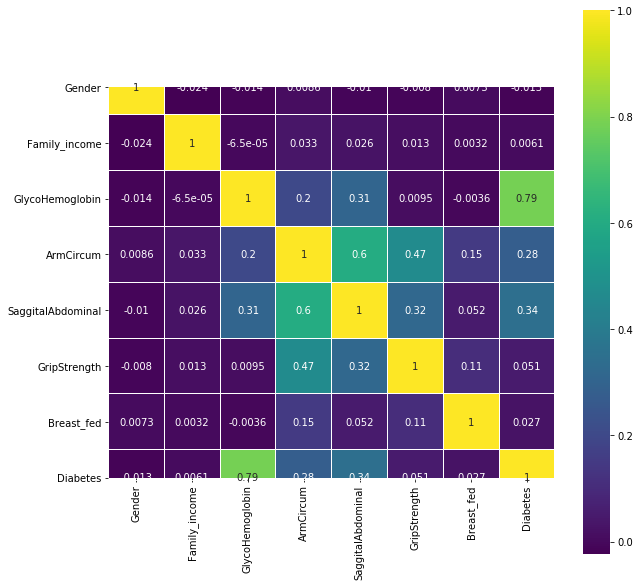

In [16]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
sns.heatmap(data.astype(float).drop(axis=1, labels='ID').corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)

Feature selection

Statistical tests can be used to select those features

that have the strongest relationship with the output variable.

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [18]:
dataframe = data#pd.read_csv(url, names=names)

In [19]:
array = dataframe.values
X =dataframe.iloc[:,0:8]  
Y = dataframe.iloc[:,8]

In [20]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=7)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['features','Score']   

print(featureScores.nlargest(10,'Score'))   

            features        Score
4          ArmCircum  1740.236266
5  SaggitalAbdominal  1043.677111
3    GlycoHemoglobin   786.654018
0                 ID   547.584364
6       GripStrength   240.922340
2      Family_income     6.614625
1             Gender     0.589742
7         Breast_fed     0.494615


Visualize feature importance

[0.05555988 0.00523305 0.05141911 0.6577796  0.07181703 0.097122
 0.05656034 0.00450898]


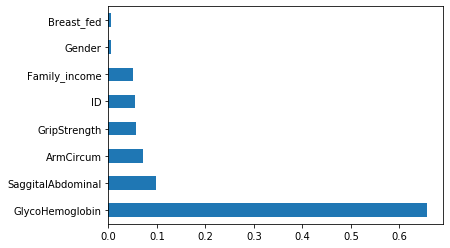

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Build models

1) Linear regression

In [22]:
from sklearn.linear_model import LinearRegression


data = dataframe.drop(['Diabetes'], axis=1)
target = dataframe[['Diabetes']]

#seperate training set and test set
train_X = data[:6000]
test_X = data[6000:]
train_Y = target[:6000]
test_Y = target[6000:]

#create linear regression obj
lr_regr = sklearn.linear_model.LinearRegression()

#training via linear regression model
lr_regr.fit(train_X, train_Y)

#make prediction using the test set
lr_pred_diabetes = lr_regr.predict(test_X)
lr_score = lr_regr.score(test_X, test_Y)

print('LRr_Coefficients: ', lr_regr.coef_)
print('LR_Mean Square Error: %.2f' % sklearn.metrics.mean_squared_error(test_Y, lr_pred_diabetes))
print('LR_Variance score: %.2f' % sklearn.metrics.r2_score(test_Y, lr_pred_diabetes))
print('Score: %.2f' % lr_regr.score(test_X, test_Y))

LRr_Coefficients:  [[ 7.08274861e-07 -4.50023303e-03 -4.00543913e-04  4.72005737e-01
   6.73036281e-03  8.15700061e-03 -5.73639121e-04  2.77201027e-02]]
LR_Mean Square Error: 0.10
LR_Variance score: 0.61
Score: 0.61


2) KMEANS

In [87]:
from sklearn.cluster import KMeans


kms = KMeans(n_clusters = 7, tol = 0.0005, algorithm="auto")

kms.fit_predict(train_X)

print ("parameters: ", kms.get_params)
print ("preict: ", kms.predict)
print ("\nscore: %.2f" % kms.score(test_X))

parameters:  <bound method BaseEstimator.get_params of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0005, verbose=0)>
preict:  <bound method KMeans.predict of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0005, verbose=0)>

score: -27234976879.42


3) Decision Tree classifier

In [75]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

#create adaboost classification obj
ab_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, 
                            learning_rate=0.5, random_state=100)

#training via adaboost classficiation model
ab_clf.fit(train_X, train_Y)
print("training....\n")

#make prediction using the test set
ab_pred_diabetes = ab_clf.predict(test_X)
print('prediction: \n', ab_pred_diabetes)

print('\nparms: \n', ab_clf.get_params)

#predict probability
#print('predict probability: %.2f' % ab_clf.staged_score(test_X, ab_pred_diabetes))

#score
ab_clf_score = ab_clf.score(test_X, test_Y)
print("\nmean accuracy: %.2f" % ab_clf.score(test_X, test_Y))

training....

prediction: 
 [0. 0. 0. ... 0. 0. 0.]

parms: 
 <bound method BaseEstimator.get_params of AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False

In [76]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [78]:
bagging = BaggingClassifier(base_estimator= DecisionTreeClassifier(), max_samples = 0.5, max_features = 0.5, 
                            bootstrap = False, bootstrap_features = False)

bagging.fit(train_X, train_Y)
bg_pred_diabetes = bagging.predict(test_X)

bg_dt_score = bagging.score(test_X, test_Y)
bagging.score(test_X, test_Y)

0.980068187778652

In [79]:
bagging = BaggingClassifier(base_estimator= KNeighborsClassifier(), max_samples = 0.5, max_features = 0.5, 
                            bootstrap = False, bootstrap_features = False)

bagging.fit(train_X, train_Y)
bg_pred_diabetes = bagging.predict(test_X)

bg_score = bagging.score(test_X, test_Y)
bagging.score(test_X, test_Y)

0.8817204301075269

4) MLP classifier

In [80]:
from sklearn.neural_network import MLPClassifier


In [81]:
mlp = MLPClassifier(hidden_layer_sizes=(1000, 300, 300), solver='adam', shuffle=False, tol = 0.0001)

mlp.fit(train_X, train_Y)
mlp_pred_diabetes = mlp.predict(test_X)

print("parameter: ", mlp.get_params())

mlp_score = mlp.score(test_X, test_Y)
mlp.score(test_X, test_Y)

parameter:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (1000, 300, 300), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': False, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


0.8806713873590348

In [82]:
d = {'Model': ['Linear Regression', 'Adaboost', 'Bagging_decision tree based', 'Bagging_KNeighbors', 'MLP'],
     'accuracy' : [lr_score, ab_clf_score, bg_dt_score, bg_score, mlp_score]}

result_df = pd.DataFrame(data = d)
result_df

,Model,accuracy
0,Linear Regression,0.609640
1,Adaboost,1.000000
2,Bagging_decision tree based,0.980068
3,Bagging_KNeighbors,0.881720
4,MLP,0.880671


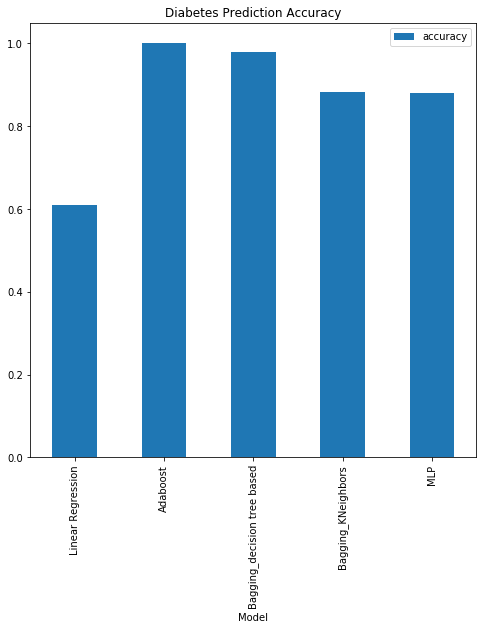

In [83]:
result_df.plot(x='Model', y='accuracy', kind='bar', figsize=(8, 8), title='Diabetes Prediction Accuracy', 
               sort_columns=True)